# <font color='#f78fb3'> Netflix Recommendations System - Word2Vec  |<br> </font>  
# <font color='#3dc1d3'>  
1.  Preprocess data
2.  Transfer Learning, using Google Pretrained Data
3.  Create Word2Vec Model
4.  Content based Recommendation System; Find 'what to watch' based which you movie you watched <br>

## <font color='#f9ca24'> Word Embedding
 <font color='00BFEB'>

## <font color='#0abde3'> Netflix Recommendations System - Word2Vec 
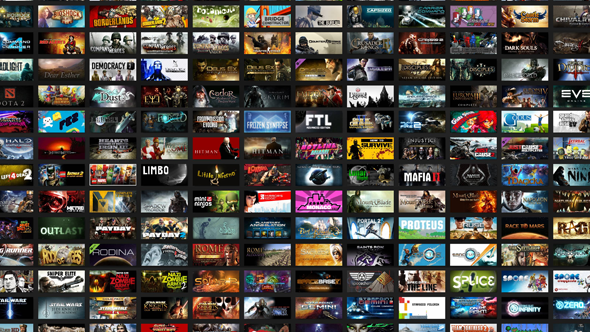



In [1]:
import pandas as pd
import numpy as np
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.metrics.pairwise import linear_kernel
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import RegexpTokenizer
import re
import string
import random
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics.pairwise import cosine_similarity
!pip install gensim #Install gensim, a useful NLP library that we will use to load w2v embeddings
from gensim.models import Word2Vec
from gensim.models.phrases import Phrases, Phraser
from matplotlib import pyplot
from gensim.models import KeyedVectors
import warnings  
warnings.filterwarnings(action='ignore',category=UserWarning,module='gensim')  
warnings.filterwarnings(action='ignore',category=FutureWarning,module='gensim') 

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\bhise\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
ERROR: Invalid requirement: '#Install'


In [2]:
from ipykernel import kernelapp as app

In [3]:
df = pd.read_csv("..\\NLP_tasks\\data\\netflix_titles.csv")

df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,81145628,Movie,Norm of the North: King Sized Adventure,"Richard Finn, Tim Maltby","Alan Marriott, Andrew Toth, Brian Dobson, Cole...","United States, India, South Korea, China","September 9, 2019",2019,TV-PG,90 min,"Children & Family Movies, Comedies",Before planning an awesome wedding for his gra...
1,80117401,Movie,Jandino: Whatever it Takes,NaN,Jandino Asporaat,United Kingdom,"September 9, 2016",2016,TV-MA,94 min,Stand-Up Comedy,Jandino Asporaat riffs on the challenges of ra...
2,70234439,TV Show,Transformers Prime,NaN,"Peter Cullen, Sumalee Montano, Frank Welker, J...",United States,"September 8, 2018",2013,TV-Y7-FV,1 Season,Kids' TV,"With the help of three human allies, the Autob..."
3,80058654,TV Show,Transformers: Robots in Disguise,NaN,"Will Friedle, Darren Criss, Constance Zimmer, ...",United States,"September 8, 2018",2016,TV-Y7,1 Season,Kids' TV,When a prison ship crash unleashes hundreds of...
4,80125979,Movie,#realityhigh,Fernando Lebrija,"Nesta Cooper, Kate Walsh, John Michael Higgins...",United States,"September 8, 2017",2017,TV-14,99 min,Comedies,When nerdy high schooler Dani finally attracts...


In [4]:
df['description'].count()

6234

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6234 entries, 0 to 6233
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       6234 non-null   int64 
 1   type          6234 non-null   object
 2   title         6234 non-null   object
 3   director      4265 non-null   object
 4   cast          5664 non-null   object
 5   country       5758 non-null   object
 6   date_added    6223 non-null   object
 7   release_year  6234 non-null   int64 
 8   rating        6224 non-null   object
 9   duration      6234 non-null   object
 10  listed_in     6234 non-null   object
 11  description   6234 non-null   object
dtypes: int64(2), object(10)
memory usage: 584.6+ KB


In [6]:
df['title'][1001]

'Gabriel and the Mountain'

In [7]:
df['description'][1001]

'In a drama based on a true story, Brazilian backpacker Gabriel Buchmann spends his gap year exploring Africa. Why does he die in the Malawi mountains?'

### Only show columns of interest

In [8]:
df2 = df[['title', 'description', 'listed_in']]
df2

,title,description,listed_in
0,Norm of the North: King Sized Adventure,Before planning an awesome wedding for his gra...,"Children & Family Movies, Comedies"
1,Jandino: Whatever it Takes,Jandino Asporaat riffs on the challenges of ra...,Stand-Up Comedy
2,Transformers Prime,"With the help of three human allies, the Autob...",Kids' TV
3,Transformers: Robots in Disguise,When a prison ship crash unleashes hundreds of...,Kids' TV
4,#realityhigh,When nerdy high schooler Dani finally attracts...,Comedies
...,...,...,...
6229,Red vs. Blue,"This parody of first-person shooter games, mil...","TV Action & Adventure, TV Comedies, TV Sci-Fi ..."
6230,Maron,"Marc Maron stars as Marc Maron, who interviews...",TV Comedies
6231,Little Baby Bum: Nursery Rhyme Friends,Nursery rhymes and original music for children...,Movies
6232,A Young Doctor's Notebook and Other Stories,"Set during the Russian Revolution, this comic ...","British TV Shows, TV Comedies, TV Dramas"


In [9]:
df.type.unique()

array(['Movie', 'TV Show'], dtype=object)

In [10]:
missing_value_count = df.isna().sum()
missing_value_count

show_id            0
type               0
title              0
director        1969
cast             570
country          476
date_added        11
release_year       0
rating            10
duration           0
listed_in          0
description        0
dtype: int64

### Visualize the length of Descriptions

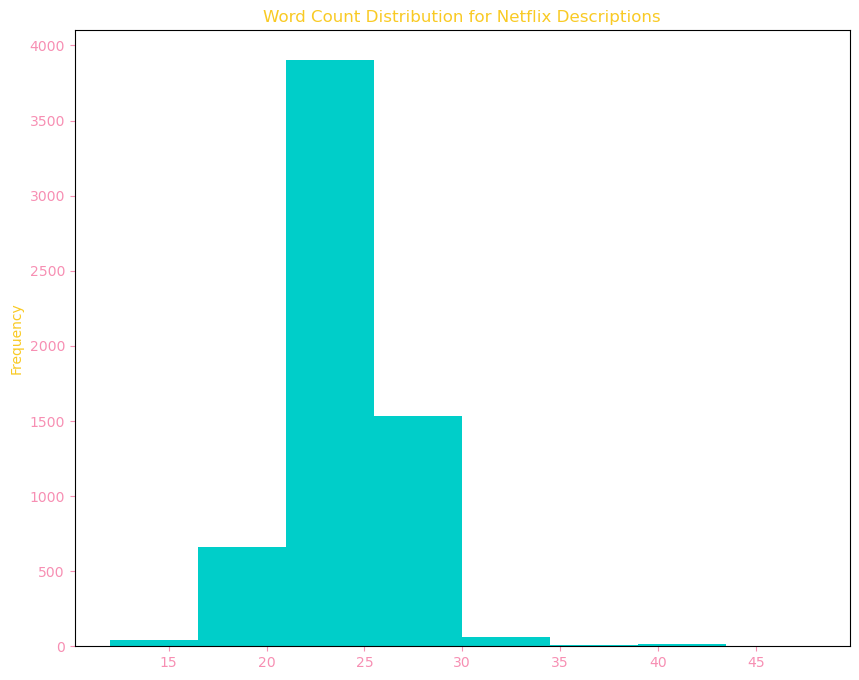

In [11]:
# a new column 'word_count' that contains the word count for each description in the 'description' column.
df['word_count'] = df['description'].apply(lambda x: len(str(x).split()))
ax = df['word_count'].plot(
    kind='hist',
    bins=8,
    color='#00cec9',
    figsize = (10,8), title="Word Count Distribution for Netflix Descriptions"
)
#add in the colour
ax.title.set_color("#f9ca24")
ax.yaxis.label.set_color("#f9ca24")
ax.xaxis.label.set_color("#f9ca24")
ax.tick_params(axis='x', colors='#f78fb3')
ax.tick_params(axis='y', colors='#f78fb3')

<font color='#3dc1d3'> Ensure Descriptions only contain strings; not float dtyp; Pandas astype() is the one of the most important methods. It is used to change data type of a series. When data frame is made from a csv file, the columns are imported and data type is set automatically which many times is not what it actually should have. For example, a salary column could be imported as string but to do operations we have to convert it into float. In this case, the series in description column; the dtype needs to be converted to string, ensure it is not float
astype() is used to do such data type conversions.

In [12]:
df['description'] = df['description'].astype(str)

 ### <font color='#f9ca24'> Preprocessing (cleaning) the Descriptions. <br>
 <font color='#3dc1d3'> Non-ASCII characters: भारत hindi;
.网络 Chinese; Hebrew
.קום, Arabic <br> Ascii - english based letters/digits/

In [13]:


def non_ascii(s):
    '''
     Python function that takes a string s as input and returns a new string containing only the characters 
     from the original string that have Unicode code points less than 128
    '''
    return "".join(i for i in s if ord(i)<128)

def lower(text):
    return text.lower()


def stop_words(text):
    '''
     The stop_words function for removing stop words from a given text. 
     It takes a text string as input and returns a new text string with the stop words removed. 
    '''
    text = text.split()#split tokens to find stop words
    stops = set(stopwords.words("english"))
    text = [w for w in text if not w in stops]
    text = " ".join(text)
    #join into a string after removing stop words 
    return text 

def clean_html(text):
    '''
    The pattern <.*?> is a regex pattern that matches any HTML tag, including the angle brackets < and >. 
    The .*? part matches any characters (represented by .*) in a non-greedy way, meaning it will stop as soon 
    as it encounters the first > character. 
    '''
    html = re.compile('<.*?>')#regex
    return html.sub(r'',text)

def punct(text):
    # Create a RegexpTokenizer to tokenize the text using word boundaries as delimiters
    token = RegexpTokenizer(r'\w+')
    
    # Tokenize the input text using the tokenizer
    text = token.tokenize(text)
    
    # Join the tokens back into a string, effectively removing punctuation
    text = " ".join(text)
    
    # Return the text with punctuation removed
    return text
 

###  <font color='#3dc1d3'>A new column is created to store the cleaned, preprocessed descriptions

In [14]:
df['new_desc'] = df['description'].apply(non_ascii)
df['new_desc'] = df.new_desc.apply(func = lower)
df['new_desc'] = df.new_desc.apply(func = stop_words)
df['new_desc'] = df.new_desc.apply(func = punct)
df['new_desc'] = df.new_desc.apply(func = clean_html)

<font color='#f9ca24'>Start Work on the Word2Vec Model<br><font color='#f78fb3'>Splitting the descriptions into words and stored in a list called ‘universe’; universe is essentially our corpus used for training our word2vec model<br>The word2vec tool takes a text corpus as input and produces the word vectors as output. It first constructs a vocabulary from the training text data and then learns vector representation of words. The resulting word vector file can be used as features in many natural language processing and machine learning applications.<br><font color='#f78fb3'>Word tokenization; break up description into word chunks

In [15]:
universe = []
for words in df['new_desc']:
    universe.append(words.split())
  #appends split-word element to the end of the list - universe 

In [16]:
universe

[['planning',
  'awesome',
  'wedding',
  'grandfather',
  'polar',
  'bear',
  'king',
  'must',
  'take',
  'back',
  'stolen',
  'artifact',
  'evil',
  'archaeologist',
  'first'],
 ['jandino',
  'asporaat',
  'riffs',
  'challenges',
  'raising',
  'kids',
  'serenades',
  'audience',
  'rousing',
  'rendition',
  'sex',
  'fire',
  'comedy',
  'show'],
 ['help',
  'three',
  'human',
  'allies',
  'autobots',
  'protect',
  'earth',
  'onslaught',
  'decepticons',
  'leader',
  'megatron'],
 ['prison',
  'ship',
  'crash',
  'unleashes',
  'hundreds',
  'decepticons',
  'earth',
  'bumblebee',
  'leads',
  'new',
  'autobot',
  'force',
  'protect',
  'humankind'],
 ['nerdy',
  'high',
  'schooler',
  'dani',
  'finally',
  'attracts',
  'interest',
  'longtime',
  'crush',
  'lands',
  'cross',
  'hairs',
  'ex',
  'social',
  'media',
  'celebrity'],
 ['young',
  'journalist',
  'forced',
  'life',
  'crime',
  'save',
  'father',
  'family',
  'series',
  'based',
  'novel',
 

In [17]:
df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,word_count,new_desc
0,81145628,Movie,Norm of the North: King Sized Adventure,"Richard Finn, Tim Maltby","Alan Marriott, Andrew Toth, Brian Dobson, Cole...","United States, India, South Korea, China","September 9, 2019",2019,TV-PG,90 min,"Children & Family Movies, Comedies",Before planning an awesome wedding for his gra...,23,planning awesome wedding grandfather polar bea...
1,80117401,Movie,Jandino: Whatever it Takes,NaN,Jandino Asporaat,United Kingdom,"September 9, 2016",2016,TV-MA,94 min,Stand-Up Comedy,Jandino Asporaat riffs on the challenges of ra...,25,jandino asporaat riffs challenges raising kids...
2,70234439,TV Show,Transformers Prime,NaN,"Peter Cullen, Sumalee Montano, Frank Welker, J...",United States,"September 8, 2018",2013,TV-Y7-FV,1 Season,Kids' TV,"With the help of three human allies, the Autob...",23,help three human allies autobots protect earth...
3,80058654,TV Show,Transformers: Robots in Disguise,NaN,"Will Friedle, Darren Criss, Constance Zimmer, ...",United States,"September 8, 2018",2016,TV-Y7,1 Season,Kids' TV,When a prison ship crash unleashes hundreds of...,20,prison ship crash unleashes hundreds deceptico...
4,80125979,Movie,#realityhigh,Fernando Lebrija,"Nesta Cooper, Kate Walsh, John Michael Higgins...",United States,"September 8, 2017",2017,TV-14,99 min,Comedies,When nerdy high schooler Dani finally attracts...,26,nerdy high schooler dani finally attracts inte...


### <font color='#f9ca24'>Transfer Learning<br><font color='#f78fb3'>using the word2vec pre-trained Google News model (GoogleNews-vectors-negative300) with the gensim Python library.<br>get GoogleNews pretrained data<br> takes a few seconds to load in gensim

<font color='#f78fb3'>embedding_file as the GoogleNews-vectors-negative300 file

In [18]:
#EMBEDDING_FILE = "..\\NLP_tasks\\data\\GoogleNews-vectors-negative300.bin" 

google_wv = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)


### <font color='#f78fb3'>Training corpus with Google Pretrained Model 

In [19]:
"""
vector_size: This parameter defines the dimensionality of the word vectors that the Word2Vec model will learn. 
In our case, we've set it to 300, which means that each word in the vocabulary will be represented 
as a 300-dimensional vector

window: The window parameter specifies the maximum distance between the current and predicted word within a sentence.
For example, if you set it to 5, the model will consider words up to 5 words away from the current word as
context words when learning word embeddings

min_count: This parameter controls the minimum number of times a word must appear in the corpus to be included
in the vocabulary. Words that occur fewer times than min_count will be ignored. Setting it to 2 means that 
words must appear at least twice in the corpus to be considered.

workers: The workers parameter specifies the number of CPU cores to use when training the Word2Vec model. 
In our case, we've set it to -1.
"""
'''
pretrained_model = Word2Vec(vector_size=300, window=5, min_count=2, workers=-1)
pretrained_model.build_vocab(universe)
pretrained_model.wv.load_word2vec_format(EMBEDDING_FILE, binary=True)
#pretrained_model.intersect_word2vec_format(EMBEDDING_FILE, lockf=1.0, binary = True)

pretrained_model.train(universe, total_examples=pretrained_model.corpus_count, epochs = 5)
'''

pretrained_model = Word2Vec(vector_size = 300, window=5, min_count = 2, workers=-1)
pretrained_model.build_vocab(universe)
#pretrained_model.intersect_word2vec_format(EMBEDDING_FILE, lockf=1.0, binary = True)
#pretrained_model.load_word2vec_format(EMBEDDING_FILE, lockf=1.0, binary = True)
#w2v_model = KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary=True)

pretrained_model.build_vocab([list(google_wv.key_to_index.keys())], update=True)
#pretrained_model.wv.intersect_word2vec_format(EMBEDDING_FILE, binary = True)
pretrained_model.train(universe, total_examples=pretrained_model.corpus_count, epochs = 7)

(0, 0)

<font color='#f78fb3'>Above: intersect_word2vec_format() <br>Merge the input-hidden weight matrix from the original word2vec format given, where it intersects with the current vocabulary/universe corpus. (What you need to note here: No words are added to the existing vocabulary, but intersecting words adopt the file’s weights, and non-intersecting words are left alone.)<br>binary is a boolean indicating whether the data is in binary word2vec format.<br>lockf is a lock-factor value to be set for any imported word-vectors; the default value of 0.0 prevents further updating of the vector during subsequent training. Use 1.0 to allow further training updates of merged vectors.<br>
<br>
The parameters:
min_count =  Ignores all words with total absolute frequency lower than this - (2, 100)<br>
window = The maximum distance between the current and predicted word within a sentence. E.g. window words on the left and window words on the left of our target - (2, 10)<br>
size = int - Dimensionality of the feature vectors. - (50, 300)<br>
sample = float - The threshold for configuring which higher-frequency words are randomly downsampled. Highly influencial. - (0, 1e-5) <br> 
workers = int - Use these many worker threads to train the model (=faster training with multicore machines)<br>
Word2Vec needs a vocabulary; (taking in the tokens and filtering out the unique ones

### <font color='#3dc1d3'>Try out the similarity between words; after intersecting with our corpus-universe

In [20]:
pretrained_model.wv.most_similar(positive=["prince"])

[('planned', 0.21960346400737762),
 ('guinea', 0.18603304028511047),
 ('pilot', 0.18494513630867004),
 ('1983', 0.18234588205814362),
 ('punchlines', 0.17997045814990997),
 ('unseen', 0.1764923632144928),
 ('neil', 0.16890588402748108),
 ('tina', 0.16614380478858948),
 ('import', 0.16316139698028564),
 ('manages', 0.16290605068206787)]

In [21]:
pretrained_model.wv.most_similar(positive=["hand"])

[('kenichi', 0.20861105620861053),
 ('anyone', 0.20707586407661438),
 ('stunt', 0.18790128827095032),
 ('catch', 0.1852473020553589),
 ('alike', 0.18364384770393372),
 ('newlywed', 0.17791344225406647),
 ('childish', 0.17654335498809814),
 ('classical', 0.17499151825904846),
 ('eve', 0.17315751314163208),
 ('weddings', 0.17276634275913239)]

In [22]:
pretrained_model.wv.similarity("king","queen")

-0.022860946

In [23]:
pretrained_model.wv.similarity("hand","queen")

-0.033178978

### <font color='#f78fb3'>The function Vectorize() defines the average word2vec for each Netflix description

In [24]:
def vectorize(x):
    global embeddings
    embeddings = []
    
    for line in df['new_desc']:
        w2v = None
        count = 0
        for word in line.split():
            if pretrained_model.wv.has_index_for(word):
                count += 1
                if w2v is None:
                    w2v = pretrained_model.wv[word]
                else:
                    w2v = w2v + pretrained_model.wv[word]
        
        if w2v is not None:
            w2v = w2v / count
            embeddings.append(w2v)

<font color='#f78fb3'>define the function to find the top 5 most similar/recommended Netflix shows, based on the one you previously watched.<br>Invert index; we have a dictionary of characters/embeddings from Description mapped to their titles, and we want to convert that to a dictionary of titles mapped to the characters that have them.<br> We trained on the descriptions of the Netflix shows but we want to search/match based on a title

In [25]:
def netflix_because_you_watched(title):
  vectorize(df)
  cosine_similarities = cosine_similarity(embeddings,embeddings)
  netflix_shows = df[['title']]#new dataframe with reversed indexes
  indices = pd.Series(df.index, index = df['title']).drop_duplicates()
  ix = indices[title]
  cosine_sim = list(enumerate(cosine_similarities[ix]))
  #enumerate adds a counter to an iteratable and returns it 
  cosine_sim = sorted(cosine_sim, key = lambda x: x[1], reverse = True)
  cosine_sim = cosine_sim[1:6] #we want the top 5 similar netflix shows 
  netflix_index = [i[0] for i in cosine_sim]
  watch_next = netflix_shows.iloc[netflix_index]
  for index, row in watch_next.iterrows():
    print(row['title'])


### <font color='#3dc1d3'>sorted() function returns a sorted list of the specified iterable object.

You can specify ascending or descending order. Strings are sorted alphabetically, and numbers are sorted numerically.
Example below: 

In [26]:
a = (1, 11, 2)
x = sorted(a)
print(x)

[1, 2, 11]


### <font color='#f9ca24'> Netflix Recommendations 


In [27]:
netflix_because_you_watched("Apaches")

Shameless (U.S.)
Club Friday The Series 8
Being Mary Jane: The Series
Hard Tide
Jack Taylor


In [28]:
netflix_because_you_watched("Friends")

Karthik Calling Karthik
Terrace House: Tokyo 2019-2020
O-Negative, Love Can’t Be Designed
Puffin Rock
Tall Girl


In [29]:
netflix_because_you_watched("Transformers Prime")

Banana Island Ghost
Fuller House
Bad Guys
Æon Flux
Trio and a Bed


In [30]:
netflix_because_you_watched("Free Willy")

Kya Kehna
Locked Up
Security
Camp Cool Kids
Pahuna


In [31]:
netflix_because_you_watched("Snowpiercer")

Earth's Natural Wonders
Niyazi Gül Dörtnala
Meet the Trumps: From Immigrant to President
The Daughter
Chicken Kokkachi
